<a href="https://colab.research.google.com/github/jillianhaig/Project3_DS4002/blob/main/SCRIPTS/3_Project3Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This code runs our model, first connecting to google drive and importing the
# images into GitHub through Google Drive, since GitHub is not large enough to store the images

In [1]:
from google.colab import drive
from google.colab import files
import zipfile
import os
import pandas as pd

drive.mount('/content/drive')

# path to the zip file on Google Drive (need to change for your path)
zip_file_path = '/content/drive/My Drive/vehicleimages.zip'

# directory where you want to extract the files
extract_to_path = '/content/vehicleimages'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print(f"Dataset unzipped to: {extract_to_path}")

image_paths = []
labels = []

vehicle_types = os.listdir(extract_to_path)

# get image paths
for vehicle_type in vehicle_types:
    vehicle_folder = os.path.join(extract_to_path, vehicle_type)

    if os.path.isdir(vehicle_folder):
        for img_file in os.listdir(vehicle_folder):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                image_path = os.path.join(vehicle_folder, img_file)
                image_paths.append(image_path)
                labels.append(vehicle_type)

df = pd.DataFrame({'image_path': image_paths, 'label': labels})

Mounted at /content/drive
Dataset unzipped to: /content/vehicleimages


# CNN Model Construction and Compiling

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# load the pre-trained ResNet50 model
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# freeze the layers to prevent updating during initial training
resnet50_base.trainable = False

# define the custom classification head
model = models.Sequential([
    resnet50_base,
    layers.GlobalAveragePooling2D(),  # Global Average Pooling layer
    layers.Dense(512, activation='relu'),  # fully connected layer
    layers.Dropout(0.5),  # dropout layer to prevent overfitting
    layers.Dense(5, activation='softmax')  # output layer with 5 units for 5 vehicle classes
])

# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 1,051,653 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Initial Model Training

In [3]:
from tensorflow.keras.callbacks import EarlyStopping

# resizing and normalizing images
image_size = (224, 224)

# create an ImageDataGenerator to load images for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# 90-10 split
train_paths, val_paths, train_labels, val_labels = train_test_split(df['image_path'], df['label'], test_size=0.1, stratify=df['label'])

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df.loc[train_paths.index],
    directory='/content',
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=df.loc[val_paths.index],
    directory='/content',
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[early_stopping]  # add EarlyStopping to stop when overfitting happens
)

Found 3920 validated image filenames belonging to 5 classes.
Found 436 validated image filenames belonging to 5 classes.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 81s 529ms/step - accuracy: 0.2640 - loss: 1.7801 - val_accuracy: 0.3624 - val_loss: 1.5045
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 61s 413ms/step - accuracy: 0.3307 - loss: 1.5211 - val_accuracy: 0.3647 - val_loss: 1.5018
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 84s 427ms/step - accuracy: 0.3280 - loss: 1.5269 - val_accuracy: 0.3761 - val_loss: 1.4663
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 56s 433ms/step - accuracy: 0.3332 - loss: 1.5106 - val_accuracy: 0.3876 - val_loss: 1.4569
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 55s 426ms/step - accuracy: 0.3472 - loss: 1.5089 - val_accuracy: 0.4014 - val_loss: 1.4454
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 80s 412ms/step - accuracy: 0.3533 - loss: 1.5057 - val_accuracy: 0.3096 - val_loss: 1.4801
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 54s 412ms/step - accuracy: 0.3452 - loss: 1.4822 - val_accuracy: 0.3876 - val_loss: 1.4142
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 107s 603ms/step - accuracy: 0.3587 - loss: 1.4734 - va

# Fine Tuning the Model

In [4]:
# unfreeze the top layers of ResNet50 for fine-tuning
for layer in resnet50_base.layers[-10:]:
    layer.trainable = True

# recompile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 81s 516ms/step - accuracy: 0.3554 - loss: 3.6612 - val_accuracy: 0.3050 - val_loss: 1.5130
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 65s 419ms/step - accuracy: 0.4117 - loss: 1.4516 - val_accuracy: 0.4587 - val_loss: 1.3766
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 83s 432ms/step - accuracy: 0.4281 - loss: 1.3967 - val_accuracy: 0.5252 - val_loss: 1.2986
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 56s 430ms/step - accuracy: 0.4610 - loss: 1.3107 - val_accuracy: 0.5894 - val_loss: 1.1219
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 82s 434ms/step - accuracy: 0.4750 - loss: 1.2867 - val_accuracy: 0.5826 - val_loss: 1.1274
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 449ms/step - accuracy: 0.4667 - loss: 1.2731 - val_accuracy: 0.6101 - val_loss: 1.0905
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 55s 429ms/step - accuracy: 0.4973 - loss: 1.2432 - val_accuracy: 0.6124 - val_loss: 1.1217
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 82s 429ms/step - accuracy: 0.5169 - loss: 1

# Evaluation and Conclusion

In [5]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


# initialize the LabelEncoder
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# list of the labels to calculate average accuracy for
labels = ["pickup", "suv", "other", "hatchback", "sedan"]

# K-fold cross-validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accuracies = []
f1_scores = []
label_accuracies = {label: [] for label in labels}

for train_idx, test_idx in kfold.split(df['image_path'], df['label_encoded']):
    # training and testing
    train_labels, test_labels = df['label_encoded'].iloc[train_idx], df['label_encoded'].iloc[test_idx]

    # prepare generators for train and test
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=df.loc[train_idx],
        directory='/content',
        x_col='image_path',
        y_col='label',
        target_size=image_size,
        batch_size=32,
        class_mode='categorical'
    )

    test_generator = validation_datagen.flow_from_dataframe(
        dataframe=df.loc[test_idx],
        directory='/content',
        x_col='image_path',
        y_col='label',
        target_size=image_size,
        batch_size=32,
        class_mode='categorical'
    )

    # train the model on the current fold
    model.fit(train_generator, epochs=50, validation_data=test_generator, callbacks=[early_stopping])

    # evaluate the model on the test set
    y_pred = model.predict(test_generator, verbose=1)
    y_true = test_labels

    # calculate overall accuracy and F1 score
    acc = accuracy_score(y_true, y_pred.argmax(axis=1))
    f1 = f1_score(y_true, y_pred.argmax(axis=1), average='weighted')

    accuracies.append(acc)
    f1_scores.append(f1)

    # calculate per-label accuracy for this fold
    for i, label in enumerate(labels):
        label_idx = label_encoder.transform([label])[0]
        label_mask = (y_true == label_idx)
        if np.sum(label_mask) > 0:
            # calculate accuracy for the current label
            label_acc = accuracy_score(y_true[label_mask], y_pred[label_mask].argmax(axis=1))
            label_accuracies[label].append(label_acc)

# average accuracy for each label across all folds
average_label_accuracies = {label: np.mean(accs) if accs else 0 for label, accs in label_accuracies.items()}

Found 3920 validated image filenames belonging to 5 classes.
Found 436 validated image filenames belonging to 5 classes.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 56s 432ms/step - accuracy: 0.5980 - loss: 1.0260 - val_accuracy: 0.6950 - val_loss: 0.7458
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 54s 413ms/step - accuracy: 0.6295 - loss: 0.9961 - val_accuracy: 0.6904 - val_loss: 0.7801
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 55s 412ms/step - accuracy: 0.6018 - loss: 1.0092 - val_accuracy: 0.6491 - val_loss: 0.8535
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 55s 424ms/step - accuracy: 0.6175 - loss: 0.9867 - val_accuracy: 0.6674 - val_loss: 0.8210
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 83s 428ms/step - accuracy: 0.6296 - loss: 0.9902 - val_accuracy: 0.6789 - val_loss: 0.7593
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 306ms/step
Found 3920 validated image filenames belonging to 5 classes.
Found 436 validated image filenames belonging to 5 classes.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 56s 433ms/step - accuracy: 0.6150 - loss: 1.0247 - val_accuracy: 0.5734 - val_loss: 1.0319
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 82s 431ms/step - accuracy: 0.6092 - loss: 0.9891 - val_accuracy: 0.5872 - val_loss: 1.0542
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 57s 442ms/step - accuracy: 0.5997 - loss: 1.0271 - val_accuracy: 0.7064 - val_loss: 0.7427
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 79s 423ms/step - accuracy: 0.6093 - loss: 1.0237 - val_accuracy: 0.7202 - val_loss: 0.7241
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 82s 426ms/step - accuracy: 0.5948 - loss: 1.0079 - val_accuracy: 0.6445 - val_loss: 0.8546
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
Found 3920 validated image filenames belonging to 5 classes.
Found 436 validated image filenames belonging to 5 classes.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 451ms/step - accuracy: 0.6203 - loss: 0.9679 - val_accuracy: 0.6697 - val_loss: 0.8604
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 55s 433ms/step - accuracy: 0.6208 - loss: 1.0145 - val_accuracy: 0.6927 - val_loss: 0.7720
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 56s 433ms/step - accuracy: 0.6272 - loss: 0.9630 - val_accuracy: 0.7041 - val_loss: 0.7523
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 55s 427ms/step - accuracy: 0.6170 - loss: 0.9864 - val_accuracy: 0.6560 - val_loss: 0.8614
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 85s 449ms/step - accuracy: 0.6322 - loss: 0.9522 - val_accuracy: 0.6995 - val_loss: 0.7363
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
Found 3920 validated image filenames belonging to 5 classes.
Found 436 validated image filenames belonging to 5 classes.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 56s 436ms/step - accuracy: 0.6098 - loss: 0.9879 - val_accuracy: 0.7179 - val_loss: 0.7282
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 55s 430ms/step - accuracy: 0.6048 - loss: 1.0016 - val_accuracy: 0.6904 - val_loss: 0.7957
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 81s 425ms/step - accuracy: 0.6168 - loss: 0.9757 - val_accuracy: 0.6697 - val_loss: 0.8509
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 58s 439ms/step - accuracy: 0.6259 - loss: 0.9766 - val_accuracy: 0.7294 - val_loss: 0.6722
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 56s 434ms/step - accuracy: 0.6318 - loss: 0.9667 - val_accuracy: 0.7041 - val_loss: 0.7702
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 56s 433ms/step - accuracy: 0.6203 - loss: 0.9649 - val_accuracy: 0.7362 - val_loss: 0.6459
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 55s 428ms/step - accuracy: 0.6204 - loss: 0.9536 - val_accuracy: 0.7523 - val_loss: 0.6565
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 82s 431ms/step - accuracy: 0.6203 - loss: 0.9741 - val

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 55s 429ms/step - accuracy: 0.6487 - loss: 0.9286 - val_accuracy: 0.7500 - val_loss: 0.6417
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 82s 426ms/step - accuracy: 0.6425 - loss: 0.9341 - val_accuracy: 0.7339 - val_loss: 0.6831
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 81s 417ms/step - accuracy: 0.6282 - loss: 0.9396 - val_accuracy: 0.7592 - val_loss: 0.6119
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 55s 412ms/step - accuracy: 0.6408 - loss: 0.9193 - val_accuracy: 0.7729 - val_loss: 0.5933
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 56s 427ms/step - accuracy: 0.6406 - loss: 0.9337 - val_accuracy: 0.7592 - val_loss: 0.6046
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 54s 418ms/step - accuracy: 0.6326 - loss: 0.9591 - val_accuracy: 0.7890 - val_loss: 0.5939
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 56s 437ms/step - accuracy: 0.6489 - loss: 0.9095 - val_accuracy: 0.7271 - val_loss: 0.6953
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 81s 430ms/step - accuracy: 0.6469 - loss: 0.9061 - val

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 54s 418ms/step - accuracy: 0.6535 - loss: 0.8933 - val_accuracy: 0.8073 - val_loss: 0.5794
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 81s 408ms/step - accuracy: 0.6684 - loss: 0.8495 - val_accuracy: 0.7867 - val_loss: 0.6020
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 81s 406ms/step - accuracy: 0.6442 - loss: 0.8940 - val_accuracy: 0.7546 - val_loss: 0.6679
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 53s 412ms/step - accuracy: 0.6635 - loss: 0.8786 - val_accuracy: 0.7683 - val_loss: 0.6060
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 84s 417ms/step - accuracy: 0.6717 - loss: 0.8514 - val_accuracy: 0.7592 - val_loss: 0.6487
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
Found 3921 validated image filenames belonging to 5 classes.
Found 435 validated image filenames belonging to 5 classes.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 65s 502ms/step - accuracy: 0.6647 - loss: 0.8749 - val_accuracy: 0.8230 - val_loss: 0.5026
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 54s 417ms/step - accuracy: 0.6795 - loss: 0.8519 - val_accuracy: 0.8023 - val_loss: 0.5812
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 55s 430ms/step - accuracy: 0.6745 - loss: 0.8825 - val_accuracy: 0.7379 - val_loss: 0.6596
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 80s 414ms/step - accuracy: 0.6809 - loss: 0.8346 - val_accuracy: 0.7770 - val_loss: 0.5919
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 53s 415ms/step - accuracy: 0.6907 - loss: 0.8569 - val_accuracy: 0.8322 - val_loss: 0.5318
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 85s 441ms/step - accuracy: 0.6699 - loss: 0.8666 - val_accuracy: 0.7701 - val_loss: 0.5673
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step
Found 3921 validated image filenames belonging to 5 classes.
Found 435 validated image filenames belonging to 5 classes.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 54s 422ms/step - accuracy: 0.6756 - loss: 0.8665 - val_accuracy: 0.7609 - val_loss: 0.5767
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 81s 413ms/step - accuracy: 0.6774 - loss: 0.8789 - val_accuracy: 0.8023 - val_loss: 0.5888
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 56s 436ms/step - accuracy: 0.6697 - loss: 0.8697 - val_accuracy: 0.7931 - val_loss: 0.5909
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 56s 426ms/step - accuracy: 0.6643 - loss: 0.8636 - val_accuracy: 0.8276 - val_loss: 0.5338
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 54s 420ms/step - accuracy: 0.6713 - loss: 0.8453 - val_accuracy: 0.8069 - val_loss: 0.5364
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
Found 3921 validated image filenames belonging to 5 classes.
Found 435 validated image filenames belonging to 5 classes.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 55s 427ms/step - accuracy: 0.6914 - loss: 0.8439 - val_accuracy: 0.7632 - val_loss: 0.6233
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 84s 445ms/step - accuracy: 0.6718 - loss: 0.8764 - val_accuracy: 0.7494 - val_loss: 0.6621
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 55s 425ms/step - accuracy: 0.6792 - loss: 0.8445 - val_accuracy: 0.8092 - val_loss: 0.5303
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 55s 425ms/step - accuracy: 0.6654 - loss: 0.8594 - val_accuracy: 0.7839 - val_loss: 0.5953
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 84s 441ms/step - accuracy: 0.6707 - loss: 0.8570 - val_accuracy: 0.7011 - val_loss: 0.7151
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
Found 3921 validated image filenames belonging to 5 classes.
Found 435 validated image filenames belonging to 5 classes.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 55s 425ms/step - accuracy: 0.6572 - loss: 0.8955 - val_accuracy: 0.7885 - val_loss: 0.5862
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 55s 425ms/step - accuracy: 0.6594 - loss: 0.8588 - val_accuracy: 0.7954 - val_loss: 0.5793
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 84s 437ms/step - accuracy: 0.6928 - loss: 0.8347 - val_accuracy: 0.7701 - val_loss: 0.6373
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 79s 414ms/step - accuracy: 0.6721 - loss: 0.8594 - val_accuracy: 0.7977 - val_loss: 0.6043
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 82s 414ms/step - accuracy: 0.6811 - loss: 0.8298 - val_accuracy: 0.7471 - val_loss: 0.6588
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


# Results and Visualization

In [6]:
# print out the results
print("Average accuracy for each label:")
for label, avg_acc in average_label_accuracies.items():
    print(f"{label}: {avg_acc:.4f}")

avg_accuracy = np.mean(accuracies)
avg_f1_score = np.mean(f1_scores)

print(f"\nAverage overall accuracy: {avg_accuracy:.4f}")
print(f"Average weighted F1 score: {avg_f1_score:.4f}")

Average accuracy for each label:
pickup: 0.4040
suv: 0.1176
other: 0.1283
hatchback: 0.0927
sedan: 0.2951

Average overall accuracy: 0.2473
Average weighted F1 score: 0.2333


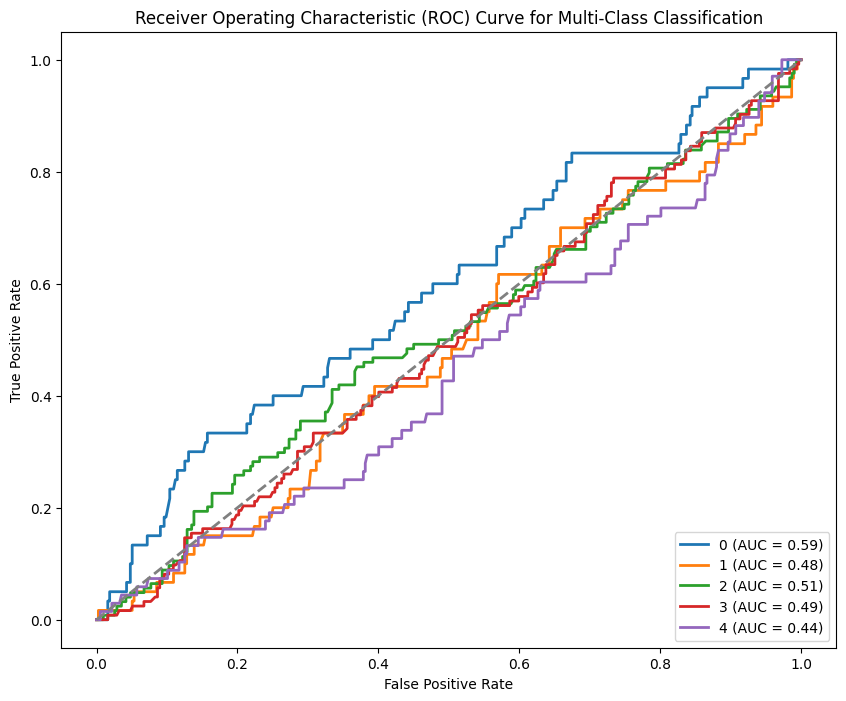

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score

y_true_all = []
y_probs_all = []

# store true labels and predicted probabilities for ROC curve
y_true_all.append(y_true)
y_probs_all.append(y_pred)

# array conversion
y_true_all = np.concatenate(y_true_all, axis=0)
y_probs_all = np.concatenate(y_probs_all, axis=0)

# Binarize the true labels (multi-class to binary for each class)
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(y_true_all)

# Plot ROC curve for each class
n_classes = y_true_bin.shape[1]
plt.figure(figsize=(10, 8))

# Loop over each class to plot its ROC curve
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs_all[:, i])
    roc_auc = auc(fpr, tpr)
    # Use lb.classes_ to get the actual class name for the index 'i'
    class_name = lb.classes_[i]
    # Plot the ROC curve for the current class with its AUC score
    plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Formatting the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class Classification')

# Show the legend with class names and AUC values
plt.legend(loc='lower right')
plt.show()
